<a href="https://colab.research.google.com/github/Chebem/Audio_Processing/blob/main/P07_Speech_Synthesis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음성 합성(Speech Synthesis)

* https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2

## Tacotron2와 WaveGlow 모델

### WaveNet (DeepMind, 2016)

- Deep generative models that directly model audio waveforms
- They use Dilated Convolutional Neural Networks to efficiently handle a large receptive field, generating very natural and human-like speech.
- They set a new standard for high-quality speech synthesis, influencing many vocoder models that followed.
- However, because they generate samples one at a time, the inference speed is very slow.

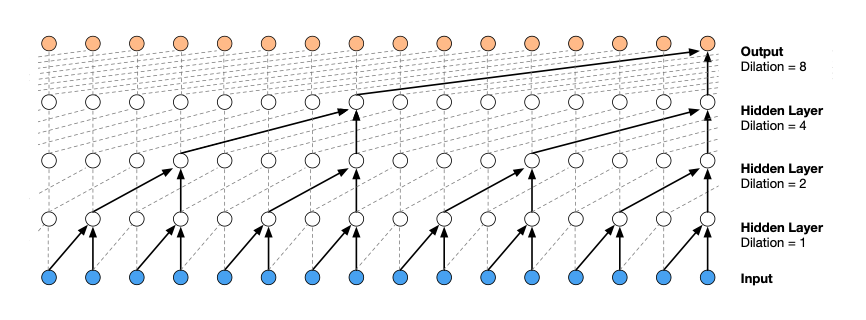

### Tacotron / Tacotron 2 (Google, 2017)
- An end-to-end sequence-to-sequence model that directly generates mel-spectrograms from text.
- Tacotron uses an encoder-decoder architecture with an attention mechanism, while Tacotron 2 combines this with a WaveNet vocoder to produce higher-quality speech.
- Demonstrated the feasibility of generating speech features directly from text in an end-to-end manner, and can achieve good performance even with relatively small amounts of data.
- Since the spectrogram is generated in an autoregressive manner, inference can be somewhat slow for real-time applications.

  
- 	https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

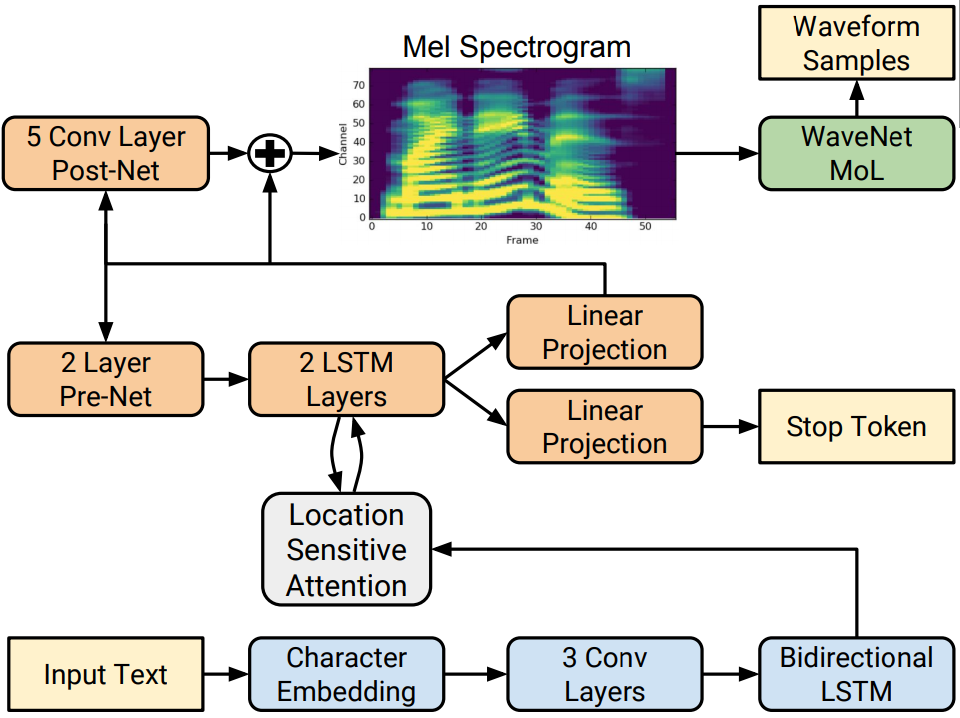

### WaveGlow (NVIDIA, 2018)

- Uses a generative modeling technique called Normalizing Flows.
-	Converts a simple distribution (e.g., Gaussian) into a complex data distribution (such as speech waveforms or spectrograms) through invertible transformations.
-	Based on the Glow model, it is a single network that directly generates audio waveforms from mel-spectrograms.
- Supports parallel generation, allowing for very fast synthesis of high-quality speech.
- Demonstrated the success of flow-based vocoders, capable of generating high-quality speech with fast training and inference.
- https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/




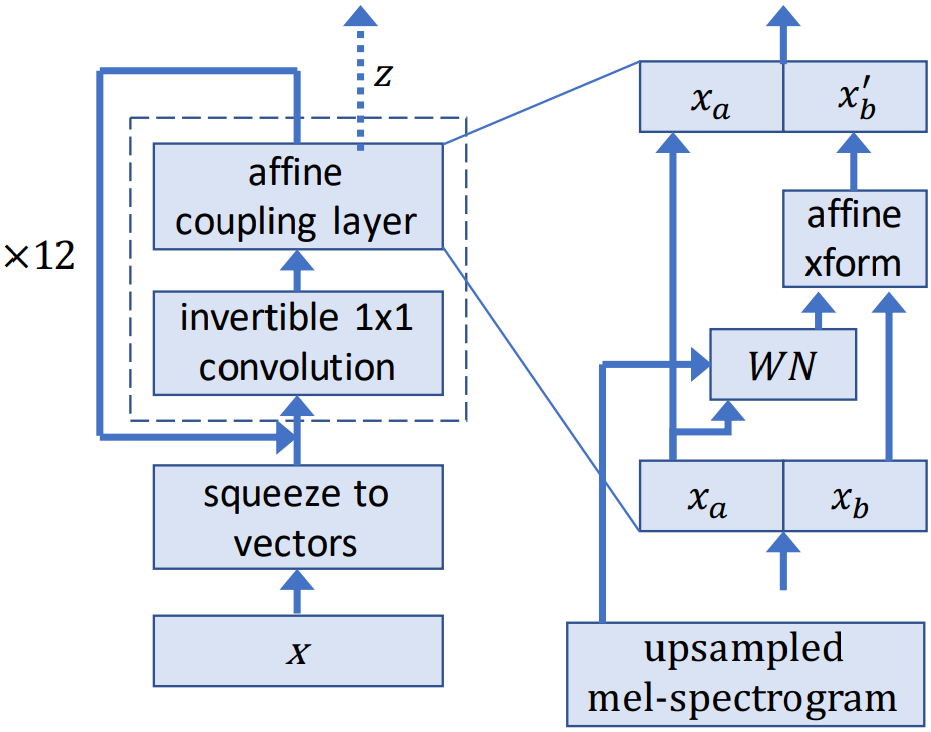

In [1]:
# @title Library Installment
!pip install numpy scipy librosa unidecode inflect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.0 MB/s eta 0:00:00


In [1]:
# @title Library Installment
!pip install numpy scipy librosa unidecode inflect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 16.0 MB/s eta 0:00:00


In [2]:
# @title Load pre-trained Tacotron2 and WaveGlow models
import torch
# Pre-trained model on the LJ Speech dataset
tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/nvidia/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [3]:
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [ ]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

In [14]:
# @title Define Speech Synthesis Function
import numpy as np
import matplotlib.pyplot as plt
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

def TTS(text):
    sampling_rate = 22050
    sequences, lengths = utils.prepare_input_sequence([text])
    sequences = sequences.to(device)
    lengths = lengths.to(device)

    with torch.no_grad():
        mel_spectrogram, mel_spec_length, attention = tacotron2.infer(sequences, lengths)
        mel_spectrogram = mel_spectrogram.to(device)
        audio = waveglow.infer(mel_spectrogram)

    mel_spectrogram = mel_spectrogram.data.cpu().numpy()[0]
    mel_spec_length = mel_spec_length.data.cpu().numpy()[0]
    attention = attention.data.cpu().numpy()[0].T
    audio_np = audio[0].data.cpu().numpy()
    return mel_spectrogram, mel_spec_length, attention, audio_np, sampling_rate

def plot_data(data, figsize=(16, 4)):
    """
    Plot mel spectrogram and attention with labeled axes.
    Args:
        data (list of 2D arrays): e.g. [mel_spectrogram, attention]
        figsize (tuple): Figure size.
    """
    titles = ["Mel-Spectrogram", "Attention Alignment"]
    ylabels = ["Mel Filterbank Index", "Decoder Time Step"]
    xlabels = ["Time Frame", "Encoder Time Step"]

    fig, axes = plt.subplots(1, len(data), figsize=figsize)

    if len(data) == 1:
        axes = [axes]  # ensure iterable if only one plot

    for i in range(len(data)):
        im = axes[i].imshow(data[i], aspect='auto', origin='bottom',
                            interpolation='none', cmap='viridis')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel(xlabels[i])
        axes[i].set_ylabel(ylabels[i])
        fig.colorbar(im, ax=axes[i])

    plt.tight_layout()
    plt.show()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [15]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to the device
tacotron2 = tacotron2.to(device)
waveglow = waveglow.to(device)

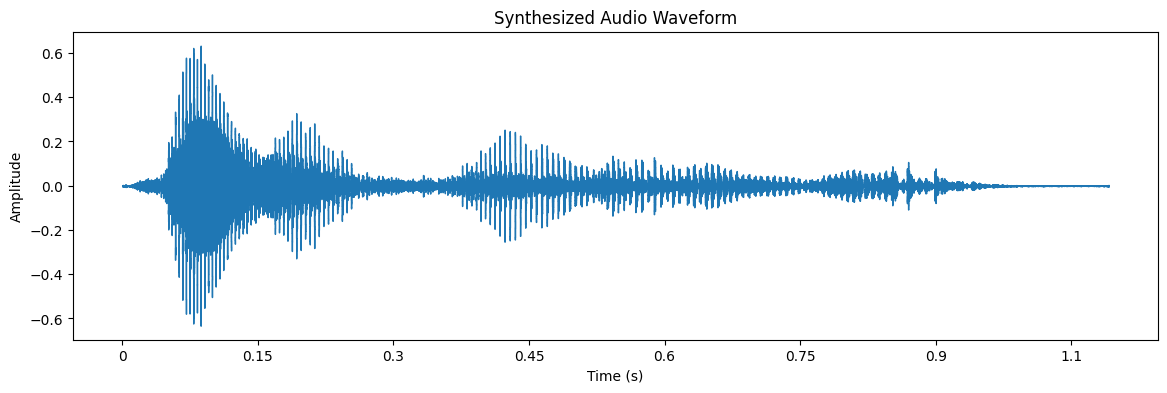

In [16]:
# @title Run Speech Synthesis
import librosa.display
from IPython.display import Audio

# Input text to synthesize
text = "Hello, how are you?"

# Generate mel spectrogram, attention, audio, and sampling rate
mel_spectrogram, mel_spec_length, attention, audio_np, rate = TTS(text)

# Plot waveform of generated audio
fig = plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio_np, sr=rate)
plt.title("Synthesized Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Play audio directly in notebook
Audio(audio_np, rate=rate)

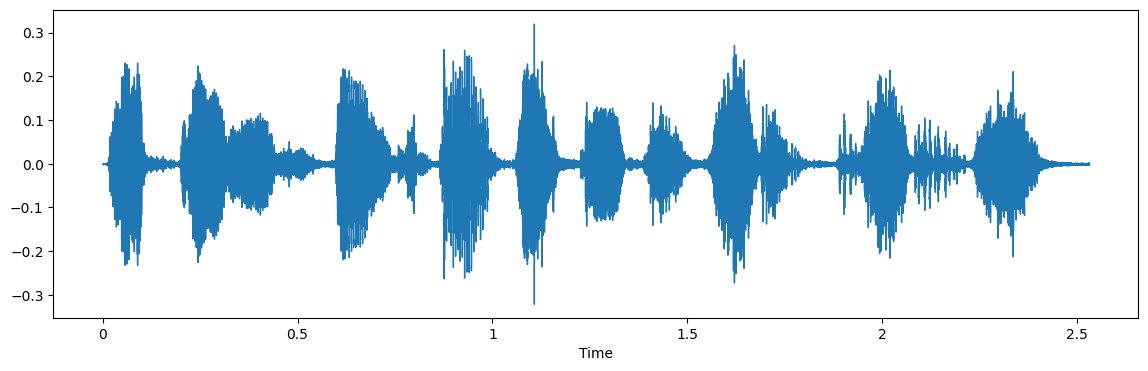

In [17]:
text = "What do you think about speech synthesis?"
mel_output, mel_output_postnet, alignments, audio_np, rate = TTS(text)
fig = plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio_np, sr=rate)
Audio(audio_np, rate=rate)

In [18]:
text = "I'll get better if I learn a lot of data."
mel_output, mel_output_postnet, alignments, audio_np, rate = TTS(text)
fig = plt.figure(figsize=(14, 4))

<Figure size 1400x400 with 0 Axes>

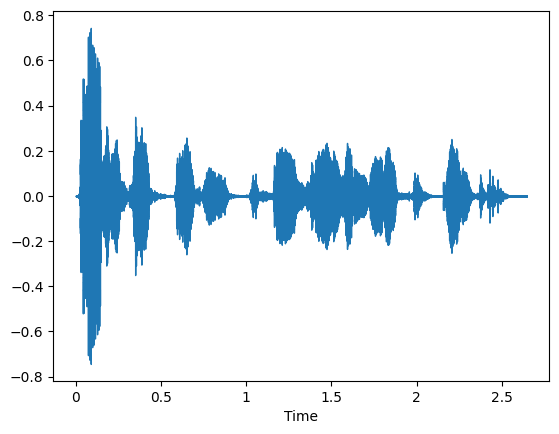

In [19]:
librosa.display.waveshow(audio_np, sr=rate)
Audio(audio_np, rate=rate)

## FastSpeech (Microsoft, 2019) / FastSpeech 2 (Microsoft, 2020)

- Based on the Transformer architecture, it generates mel spectrograms in parallel.
- FastSpeech introduced a Duration Predictor trained using an external aligner to enable non-autoregressive generation.
- FastSpeech 2 further enhances this by also predicting prosodic features like pitch and energy, while simplifying the training process.
- It achieves generation speeds tens to hundreds of times faster than autoregressive models while maintaining comparable quality, paving the way for real-time TTS.
-	However, it may depend on external aligners or pretrained models to obtain duration information.
- It can struggle with the “one-to-many” problem, where a single text may have multiple valid speech expressions.




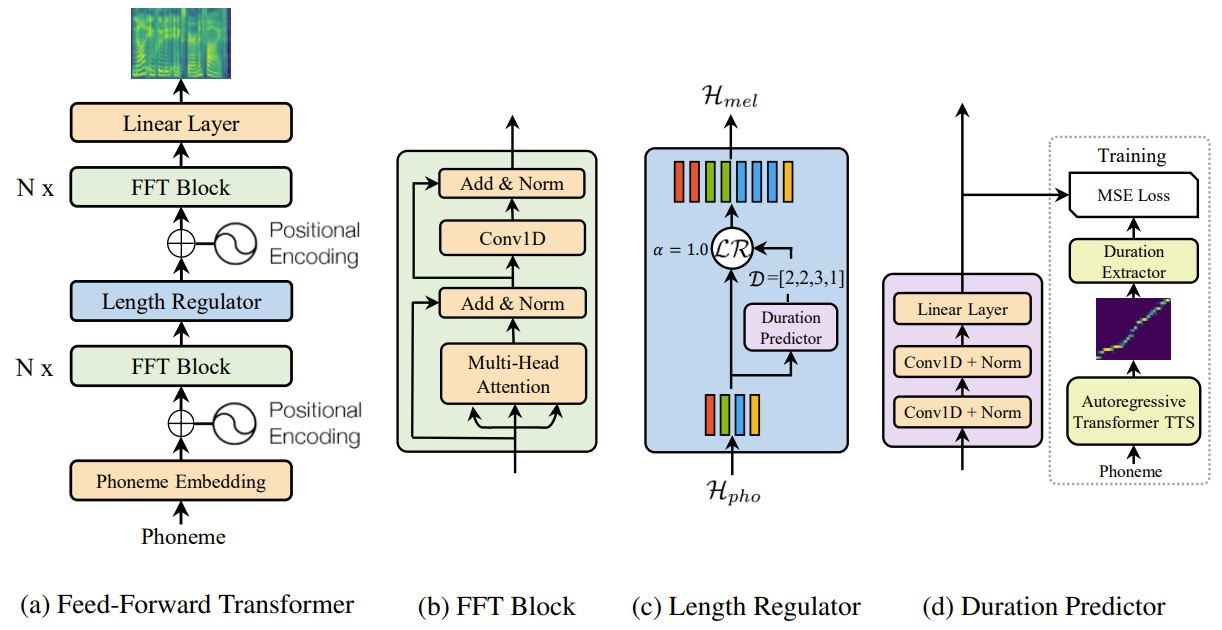

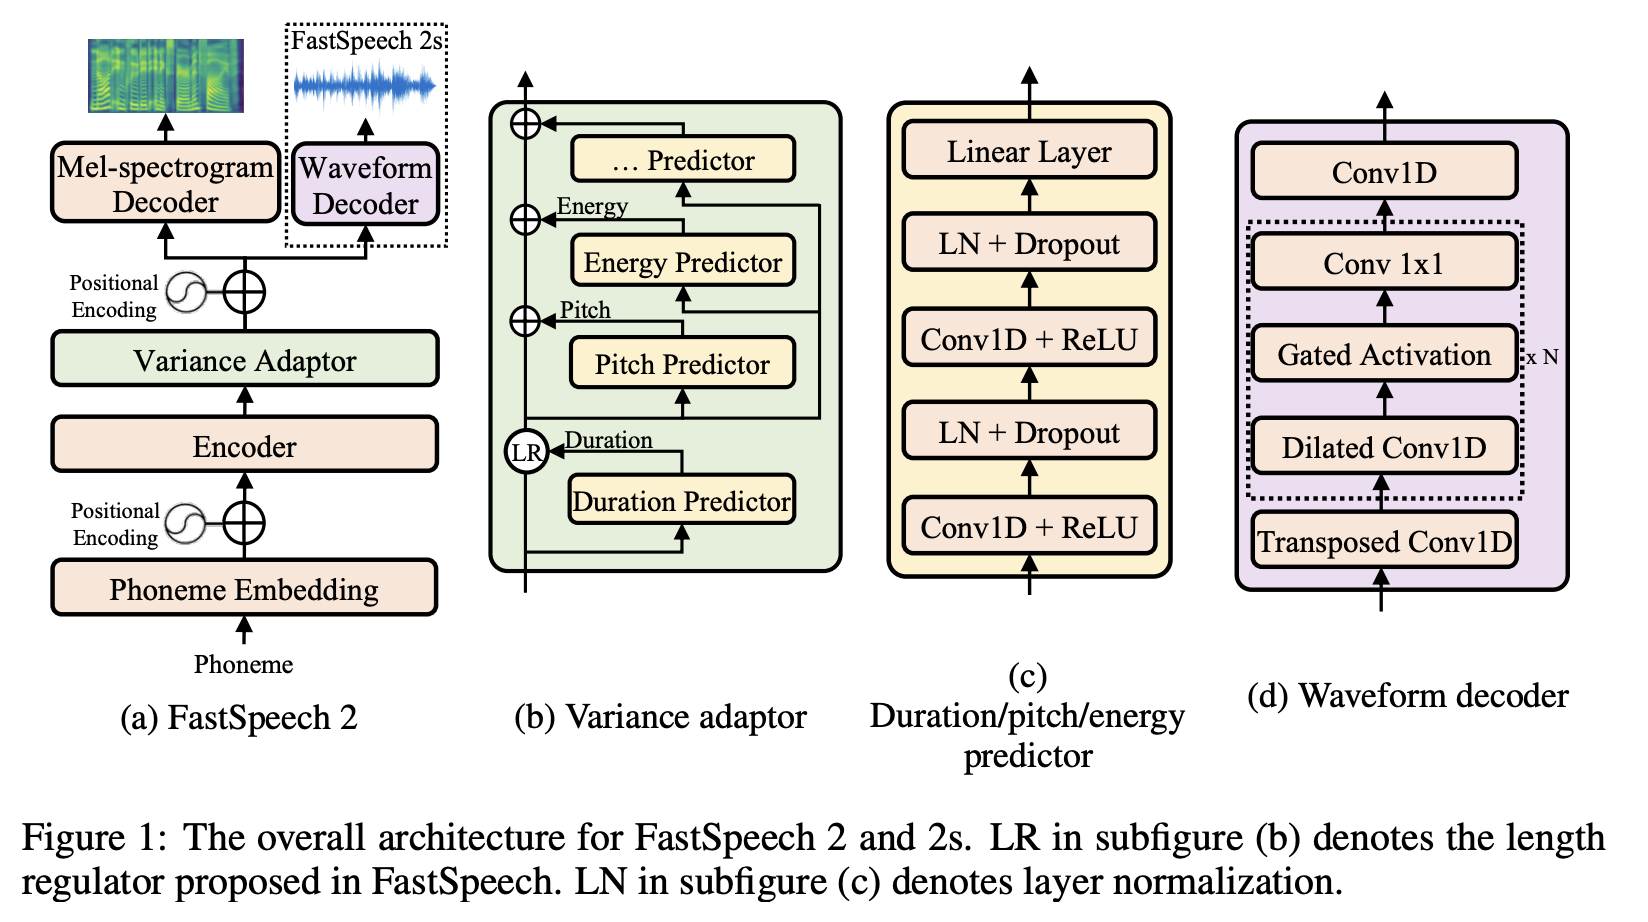

### HiFi-GAN (KAIST, 2020)

-	A GAN-based neural vocoder for high-quality speech waveform synthesis.
- Input: Mel-spectrogram
- Output: Raw audio waveform

Generator
- 	Based on the MelGAN generator architecture, uses transposed convolutions for upsampling.
- Efficiently generates raw waveforms from input mel spectrograms.

Discriminator
- Multi-Period Discriminator (MPD):
Captures periodic patterns in speech to reduce pitch-related artifacts.
Converts signals into 2D representations by sampling at fixed intervals.
- 	Multi-Scale Discriminator (MSD):
Detects continuity and long-term dependencies across different temporal scales.
Operates on both raw and downsampled waveforms.
-	Operates in a non-autoregressive manner, making it suitable for real-time synthesis.
-	Achieves speech quality comparable to autoregressive models like WaveNet.
- Can be configured with relatively few parameters.
- Strikes a strong balance between speed and quality, making it a standard vocoder in many modern TTS systems.

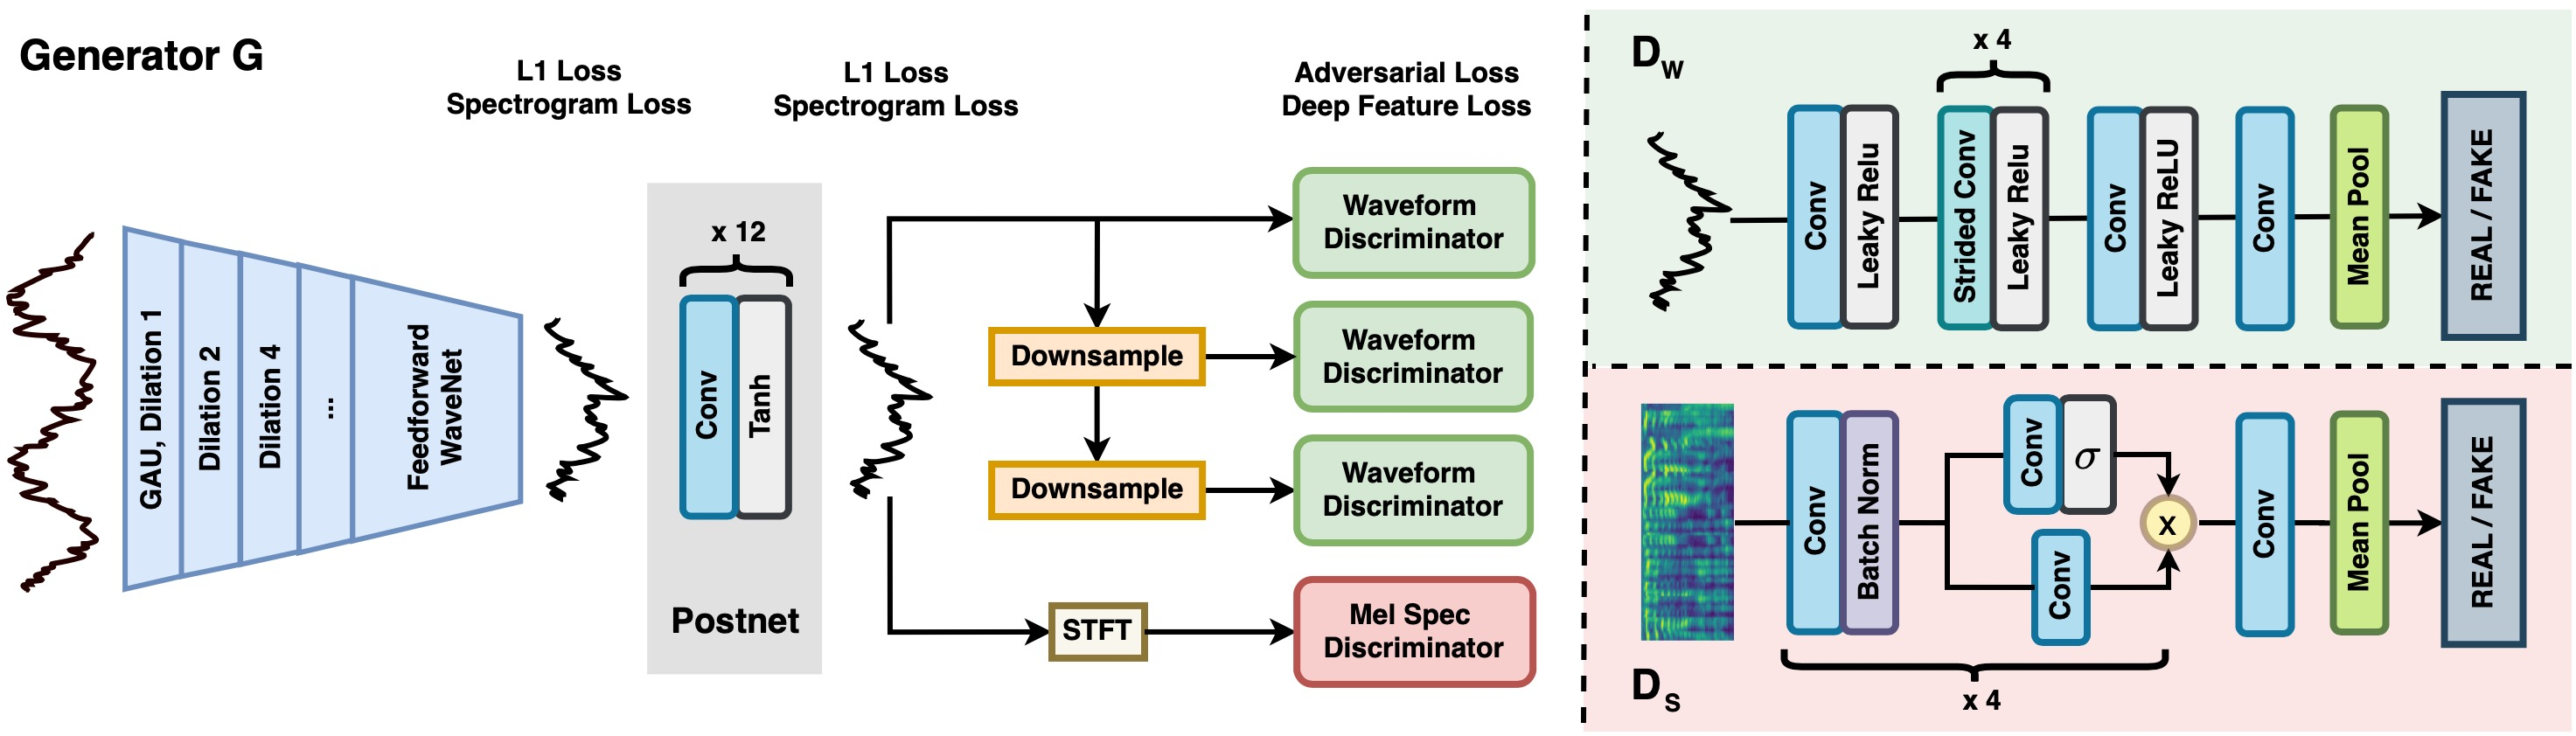

## HiFi-GAN V2

-	An improvement over HiFi-GAN V1, with enhanced discriminator structure and training strategy aimed at studio-quality speech synthesis.
- Introduces the Multi-Resolution STFT Discriminator (MRSD):
Unlike the original Multi-Scale Discriminator (MSD), which operates on raw time-domain waveforms, MRSD works in the time-frequency domain.
-	Performs multi-scale discrimination on STFT (Short-Time Fourier Transform) spectrograms with varied resolutions (different FFT sizes, window sizes, hop sizes).
- Provides a more detailed evaluation of generated audio in the time-frequency space, helping reduce artifacts and subtle noise.
-	Enhancing the discriminator leads the generator to produce audio that is closer to natural speech.
-	The generator retains a similar structure to HiFi-GAN V1 or applies slight modifications, with the main improvements focused on the discriminator.
-	Improved audio quality compared to V1, particularly reducing fine-grained noise and metallic artifacts.
-	Aims for studio-level high-fidelity speech synthesis.
- Maintains fast inference speed of HiFi-GAN V1.
-	Pushes the quality of GAN-based vocoders further, enabling highly natural and clean speech synthesis.

⸻


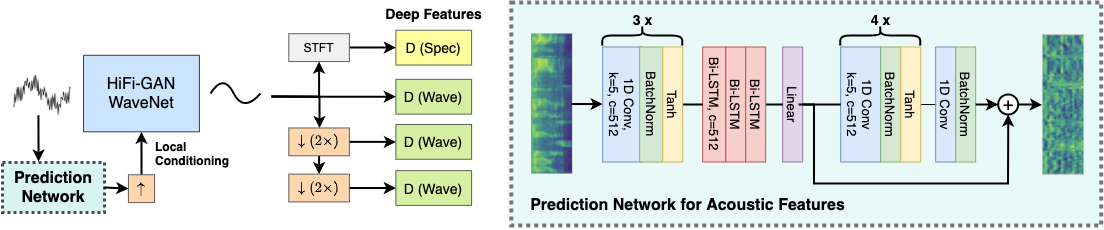

# Major Text-to-Speech (TTS) Models Since 2020

## Glow-TTS (2020, Kakao Enterprise)
-	Uses flow-based generative modeling to generate mel spectrograms in parallel from text.
-  Introduces Monotonic Alignment Search (MAS) for stable alignment learning.
- Demonstrates that flow-based models can achieve fast and high-quality synthesis simultaneously.

## VITS (2021, KAIST)
- 	An end-to-end TTS model that combines VAE, normalizing flows, and GANs.
-	Directly generates raw audio from text using stochastic latent variables, enabling expressive and diverse speech synthesis.
- Offers state-of-the-art audio quality and fast inference, remaining a benchmark model.

⸻


## Grad-TTS (2021, NVIDIA)
- One of the first major TTS models to apply Denoising Diffusion Probabilistic Models (DDPM).
-	Gradually refines mel spectrograms conditioned on input text.
-	Demonstrates that diffusion models can produce high-quality audio in TTS.


## YourTTS (2021, Edresson Casanova et al.)
- Based on the VITS architecture, supports zero-shot multi-speaker and multilingual speech synthesis.
- Can clone a speaker’s voice using just a short reference audio sample.
- Significantly advanced the field of zero-shot voice cloning.


## NaturalSpeech (2022, Microsoft)
- a VAE-based phoneme encoder and a diffusion-based decoder.]
- Trained on large-scale speech-text pairs.
-	Produces natural, prosodic speech, reported to be indistinguishable from human speech in some evaluations.


## StyleTTS (2022, Yoon Kim et al.) / StyleTTS 2 (2023, Yinghao Aaron Li et al.)
-Focuses on extracting and controlling style directly from reference speech, without explicit style embeddings.
- StyleTTS 2 (2023, Yinghao Aaron Li et al.):
Uses diffusion models to generate even higher-quality and more controllable speech.
Advances fine-grained style control in neural TTS.

## VALL-E (2023, Microsoft)
- Applies large language model (LLM) principles to TTS.
- Predicts discrete audio codec tokens, allowing zero-shot voice cloning from just 3 seconds of reference audio.
- Can mimic emotions and acoustic conditions, demonstrating a paradigm shift in LLM-based speech synthesis.

## NaturalSpeech 2 (2023, Microsoft)
- Successor to NaturalSpeech, now using latent diffusion models for greater efficiency.
- Models richer content using neural audio codecs and duration predictors, enhancing zero-shot TTS quality.

- Sets a new bar for naturalness and prosody in zero-shot speech synthesis.

⸻


## XTTS (Coqui, 지속 개발 중)
- 	Based on TortoiseTTS, XTTS is an open-source few-shot TTS and multilingual voice cloning model.
Utilizes a VITS-like architecture, capable of cloning voices from small amounts of audio.
	•	Increases accessibility to high-performance voice cloning in open-source.

⸻


## Bark (Suno AI) (2023)
- A Transformer-based text-to-audio model that generates not only speech, but also music, background noise, and non-verbal sounds (e.g., laughter, sighs).
- Excels at generating expressive and stylistic audio, especially in non-verbal expression.
- Built on a GPT-style architecture.

## Diff-TTS 계열 모델
-	Refers to models applying Denoising Diffusion Probabilistic Models (DDPM) to TTS.
- Generates high-quality mel spectrograms or waveforms by gradually denoising from noise.
- Offers stable training and superior sample quality compared to GAN-based models.
-	Includes various derivatives like Grad-TTS, ProDiff, etc.

⸻
